# Image registration helper  

*Development notebook for ipyleaflet based `ImageRegistrationHelper`.*

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack 

In [ ]:
from maxrf4u import DataStack 

ds = DataStack('RP-T-1898-A-3689.datastack') 

x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)

is_iron_Ka_band = (x_keVs > 6.1) * (x_keVs < 6.7) 

FeKa_slice = cube[:,:,is_iron_Ka_band].compute() # load only this slice into memory 
FeKa_map = FeKa_slice.sum(axis=2) / 60 # number of channels in the Fe_Ka band 

In [ ]:
susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

im_src = susanna_highres
im_dst = FeKa_map 

# corner points for image registration 
#pts_src = np.array([[78.5, 204.6], [4340.1, 180.4], [4374.9, 4724.9], [110.1, 4766.3]])
#pts_dst = np.array([[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]])

#imvis_reg_highres, extent = warp(im_src, im_dst, pts_src, pts_dst, rgba=False)
#imvis_reg, extent = warp(im_src, im_dst, pts_src, pts_dst, keep_scale=False, rgba=False)

In [ ]:
#src_url, src_shape  = img_to_url(im_src) 
#dst_url, dst_shape = img_to_url(np.clip(im_dst, a_min=0, a_max=3))

Seems critical to inherit from object 
Saw this here: https://stackoverflow.com/questions/55763382/get-ipywidget-button-within-a-class-to-access-class-parameters-through-self

## FUNCTIONS 

In [ ]:
from IPython.display import display 
import ipyleaflet as ipl 
from ipywidgets import Text, HTML, Layout, HBox, VBox 
import ipywidgets 
from ipyleaflet import Map, ImageOverlay, basemap_to_tiles, Marker, WidgetControl
  
import io 
import matplotlib.pyplot as plt
import numpy as np
import base64 
import skimage.transform as skt 


def img_to_url(img_data, max_width=None): 
    '''Filename or numpy array *img_data* is transformed into base64 encoded url string. 
    
    To compress image specify thumbnail `width`. 
    
    Returns: url_string, shape'''
        
    try: 
        img = plt.imread(img_data) # if img_data is an image file path 
    except: 
        img = img_data # assuming img_data is an image like numpy array  
        
    shape = img.shape[0:2] # height and width only 
    h, w = shape 
    
    # rescaling image if width > max_width 
    if max_width is not None:  
        if w > max_width:
            scale = max_width / w  
            img = skt.rescale(img, scale, multichannel=True) 
    

    buff = io.BytesIO();
    plt.imsave(buff, img, format='png')
    plt.close()

    base64_string = base64.b64encode(buff.getvalue()).decode("ascii")
    url_string = f'data:image/png;base64,{base64_string}' 
    
    return url_string, shape 


def mark_corners(map_, img_shape): 

    h, w = img_shape[0:2] 

    corners = [[h, 0], [h, w], [0, w], [0, 0]] 
    colors = ['red', 'green', 'blue', 'orange']
    labels = ['top left', 'top right', 'bottom right', 'bottom left']

    markers = [] 

    for location, color, label in zip(corners, colors, labels): 
        icon = ipl.AwesomeIcon(name='circle-o', marker_color=color)
        marker = Marker(location=location, draggable=True, title=f'Drag me to {label} landmark', icon=icon)
        markers.append(marker)
        map_.add(marker) 
    
    return markers 


# callback 
def on_marker_move(change): 
    
    textbox.value = extract_corner_points(src_markers, src_shape, dst_markers, dst_shape, return_text=True)

    
    
def extract_corner_points(src_markers, src_shape, dst_markers, dst_shape, return_text=False): 
    '''Flip coordinates to make top of image zero. 
    
    Returns: pts_string 
    '''
    
    src_pts = []
    h, w = src_shape 
    for marker in src_markers:   
        y, x = marker.location 
        xy_flip = [ x - 0.5, h - y - 0.5]
        src_pts.append(xy_flip)
             
    dst_pts = []
    h, w = dst_shape  
    for marker in dst_markers:   
        y, x = marker.location 
        xy_flip = [ x - 0.5, h - y - 0.5]
        dst_pts.append(xy_flip)
        
    if return_text:     
        # two decimal strings for textbox 
        src_pts_string = 'src_pts = ' + ', '.join([f'[{y:.02f}, {x:.02f}]' for [y, x] in src_pts])
        dst_pts_string = 'dst_pts = ' + ', '.join([f'[{y:.02f}, {x:.02f}]' for [y, x] in dst_pts])

        pts_string = f'# corner points for image registration: \n{src_pts_string}\n{dst_pts_string}'

        return pts_string 
    
    else: 
        return src_pts, dst_pts 

# seems critical to inherit from object!  
# saw this here: 
# https://stackoverflow.com/questions/55763382/get-ipywidget-button-within-a-class-to-access-class-parameters-through-self
class ImageRegistrationHelper(object): 
    
    def on_marker_move_(self, change): 
            
            self.textbox.value = extract_corner_points(self.src_markers, self.src_shape, 
                                                       self.dst_markers, self.dst_shape, 
                                                       return_text=True) 
            
    def get_corner_points_for_image_registration(self, verbose=True): 
        '''Get 4 source and 4 destination corner points for image registration. 
        
        Extracts current positions from all markers. Output can be used in warp function. 
        
        Returns: src_points, dst_points
        '''
        
        src_points, dst_points = extract_corner_points(self.src_markers, self.src_shape, 
                                           self.dst_markers, self.dst_shape, 
                                           return_text=False)
        
        print(f'src_points = {src_points}\ndst_points = {dst_points}')
        
        src_points = np.array(src_points) 
        dst_points = np.array(dst_points)
        
        return src_points, dst_points 
        
    
    def __init__(self, src_imdata, dst_imdata): 
        
        layout = Layout(width='500px', height='500px')
        resolutions = [256 * 2 ** (-l) for l in range(20)]
 
        crs = dict(name='Pixelcoords', custom=True, bounds=[[0, 0], [1000, 1000]], origin=[0, 0], 
                    resolutions=resolutions, proj4def='+proj=longlat')
    

        # read images and convert to png/base64 url  
        src_url, self.src_shape = img_to_url(src_imdata) 
        dst_url, self.dst_shape = img_to_url(dst_imdata) 
        
        
        src_h, src_w = self.src_shape 
        self.src_map = Map(scroll_wheel_zoom=True, crs=crs, center=[src_h/2, src_w/2], zoom=4, 
                      layout=layout, interpolation='nearest')

        dst_h, dst_w = self.dst_shape
        self.dst_map = Map(scroll_wheel_zoom=True, crs=crs, center=[dst_h/2, dst_w/2], zoom=4, 
                      layout=layout, interpolation='nearest')
        
        self.src_markers = mark_corners(self.src_map, self.src_shape)
        self.dst_markers = mark_corners(self.dst_map, self.dst_shape)

        src_imo = ImageOverlay(url=src_url, bounds=[[0, 0], self.src_shape]) # SW and NE corners
        dst_imo = ImageOverlay(url=dst_url, bounds=[[0, 0], self.dst_shape]) # SW and NE corners

        self.src_map.add(src_imo)
        self.dst_map.add(dst_imo)

        # this hack removes the default world map layer 
        # (seems I can do that only after creating other widgets) 
        self.src_map.remove(self.src_map.layers[0]) 
        self.dst_map.remove(self.dst_map.layers[0])

        for marker in self.src_markers: 
            marker.observe(self.on_marker_move_)

        for marker in self.dst_markers: 
            marker.observe(self.on_marker_move_)

        # initialize textbox    
        self.pts_string = extract_corner_points(self.src_markers, self.src_shape, 
                                           self.dst_markers, self.dst_shape, 
                                           return_text=True)

        self.textbox = ipywidgets.Textarea(self.pts_string, rows=3, layout=Layout(width='100%'))

        self.combi = VBox([HBox([self.src_map, self.dst_map]), self.textbox])
        
        display(self.combi)

       

In [ ]:
imreg = ImageRegistrationHelper(im_src, np.clip(im_dst, a_min=0, a_max=3))

In [ ]:
src_points, dst_points = imreg.get_corner_points_for_image_registration()

src_points = [[77.00030809027965, 204.5], [4335.12553915799, 147.5], [4371.37517971933, 4717.75], [103.98695751149549, 4761.0]]
dst_points = [[24.499794606480243, 7.0], [1575.6217393778738, -0.5], [1562.250975619219, 1663.25], [6.499589212960487, 1669.875]]


In [ ]:
from maxrf4u import warp

In [ ]:
im_reg, extent = warp(im_src, im_dst, src_points, dst_points, rgba=False, keep_scale=True)

<IPython.core.display.Javascript object>


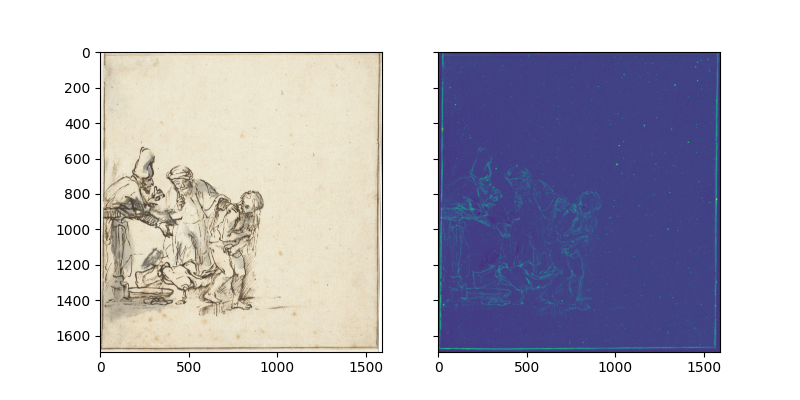

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[8, 4])
ax.imshow(im_reg, extent=extent)
ax1.imshow(np.clip(im_dst, a_min=0, a_max=3))

In [ ]:
layout = Layout(width='500px', height='500px')

# need to include resolutions, otherwise no zoom buttons!!  
resolutions = [256 * 2 ** (-l) for l in range(20)]
 
proj = dict(name='Pixelcoords', custom=True, bounds=[[0, 0], [1000, 1000]], origin=[0, 0], 
            resolutions=resolutions, 
            proj4def='+proj=longlat') # seems that esu to make no difference 
            # proj4def='+proj=longlat +axis=esu')

src_h, src_w = src_shape 
src_map = Map(scroll_wheel_zoom=True, crs=proj, center=[src_h/2, src_w/2], zoom=4, 
              layout=layout, interpolation='nearest')

dst_h, dst_w = dst_shape
dst_map = Map(scroll_wheel_zoom=True, crs=proj, center=[dst_h/2, dst_w/2], zoom=4, 
              layout=layout, interpolation='nearest')

src_markers = mark_corners(src_map, src_shape)
dst_markers = mark_corners(dst_map, dst_shape)

src_imo = ImageOverlay(url=src_url, bounds=[[0, 0], src_shape]) # SW and NE corners
dst_imo = ImageOverlay(url=dst_url, bounds=[[0, 0], dst_shape]) # SW and NE corners

src_map.add(src_imo)
dst_map.add(dst_imo)

# this removes the default world map layer 
# seems I can do that only after creating other widgets 
src_map.remove(src_map.layers[0]) 
dst_map.remove(dst_map.layers[0])

for marker in src_markers: 
    marker.observe(on_marker_move)
    
    
for marker in dst_markers: 
    marker.observe(on_marker_move)

# initialize 
pts_string = extract_corner_pts(src_markers, src_shape, dst_markers, dst_shape, string=True)

textbox = ipywidgets.Textarea(pts_string, 
                              rows=3, layout=Layout(width='50%'))
    
VBox([HBox([src_map, dst_map]), textbox])

In [ ]:
src_pts, dst_pts = extract_corner_pts(src_markers, src_shape, dst_markers, dst_shape)
dst_pts

[[7.75, 24.937589859664893],
 [-2.2737367544323206e-13, 1576.4969190972038],
 [1663.125, 1562.0001026967598],
 [1669.25, 10.999897303240118]]

In [ ]:
import ipywidgets

In [ ]:
pts = extract_corner_pts(src_markers, src_shape, dst_markers, dst_shape);
pts)

'([[0, 0], [0, 4396], [4920, 4396], [4920, 0]], [[0, 0], [0, 1592], [1692, 1592], [1692, 0]])'

In [ ]:
textbox.value = 'qwerty'

In [ ]:
print(f'{1/3:.02f}')

0.33


In [ ]:
extract_corner_pts(src_markers, src_shape, dst_markers, dst_shape);

[[1320, 688.0887300005343], [0, 4396], [4920, 4396], [4840, 448.0920162968505]] [[7.984375, 25.031256418547493], [0, 1592], [1692, 1592], [1692, 0]]


In [ ]:
# corner points for image registration 
#pts_src = np.array([[78.5, 204.6], [4340.1, 180.4], [4374.9, 4724.9], [110.1, 4766.3]])
#pts_dst = np.array([[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]])

def extract_corner_pts(src_markers, src_shape, dst_markers, dst_shape): 
    '''Flip coordinates to make top zero. 
    
    Can't figure out how to do that natively in the Map widget yet.;-)
    '''
    
    src_pts = []
    h, w = src_shape 
    for marker in src_markers:   
        y, x = marker.location 
        yx_flip = [h - y, x]
        src_pts.append(yx_flip)
        
    dst_pts = []
    h, w = dst_shape  
    for marker in dst_markers:   
        y, x = marker.location 
        yx_flip = [h - y, x]
        dst_pts.append(yx_flip) 
        
    print(src_pts, dst_pts, end='\r')
        
    return src_pts, dst_pts
    
    

In [ ]:
on_marker_move??

#hide 
## Ipyleaflet it is 

*Slowly learning how to get rid of the base map and adding dragable markers...* 

Think like a tiled image of your dog:

https://stackoverflow.com/questions/65478105/ipyleaflet-create-your-own-arbitrary-non-geographic-coordinate-system-basemap

Also a good intro: https://towardsdatascience.com/ipyleaflet-interactive-mapping-in-jupyter-notebook-994f19611e79 

Combining a map and a Lat, Lon text box: https://github.com/jupyter-widgets/ipyleaflet/issues/203

Base64 png: https://github.com/jupyter-widgets/ipyleaflet/issues/550

**Now include pixelmap crs like so:**
```
proj = dict(
    name='PixelSpace',
    custom=True,
    # The 20 is arbitrary -- it could just be defined for the zoom levels we can reach, but going higher doesn't cause any issues
    resolutions=[256 * 2 ** (-l) for l in range(20)],
    # This works but has x and y reversed
    # The s in esu inverts the y axis so 0,0 is at the top left not the bottom right
    proj4def='+proj=longlat +axis=esu',
    bounds=[[0,0],[metadata['sizeY'],metadata['sizeX']]],
    origin=[0,0],
)
```

Next issues to solve: 

* Numpy array to base64 url 

See: https://github.com/jupyter-widgets/ipyleaflet/issues/550


* No interpolation to see actual pixels 

In [ ]:
import io
#import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import base64 
import skimage.transform as skt 

#from skimage.transform import rescale, resize  
import re 

def array_to_url(img_data, width=None): 
    '''Filename or numpy array *img_data* is transformed into base64 encoded string and image tag'''
        
    try: 
        img = plt.imread(img_data) # if img_data is an image file path 
    except: 
        img = img_data # assuming img_data is an image like numpy array  

    # rescaling image
    if width is not None: 
        shape = img.shape 
        scale = width / shape[1]  
        img = skt.rescale(img, scale, multichannel=True) 
    #self.height, self.width = img.shape[0:2]

    b = io.BytesIO();
    plt.imsave(b, img, format='png')
    plt.close()

    base64_string = base64.b64encode(b.getvalue()).decode("ascii")
    url_string = f'data:image/png;base64,{base64_string}' 
    
    return url_string

    

In [ ]:
url_string = array_to_url('Primrose.jpg')

In [ ]:
url_string

''

In [ ]:
class Base64_Thumbnail:
    '''Base64 thumbnail class'''
    
    
    def __init__(self, img_data, width=200): 
        '''Filename or numpy array *img_data* is transformed into base64 encoded string and image tag'''
        
        try: 
            img = plt.imread(img_data) # if img_data is an image file path 
        except: 
            img = img_data # assuming img_data is an image like numpy array  
        
        # rescaling image
        shape = img.shape 
        scale = width / shape[1]  
        img = rescale(img, scale, multichannel=True) 
        self.height, self.width = img.shape[0:2]
        
        b = io.BytesIO();
        plt.imsave(b, img, format='png')
        plt.close()
        
        self.base64 = base64.b64encode(b.getvalue()).decode("ascii")
        self.img_tag = f'''<img src="data:image/png;base64,{self.base64}">''' 

# Ideas

## One possibility is straight from matplotlib 

https://scipy-cookbook.readthedocs.io/items/Matplotlib_Drag_n_Drop_Text_Example.html

In [ ]:
from matplotlib import pylab as p
from matplotlib.text import Text

class DragHandler(object):
    """ A simple class to handle Drag n Drop.

    This is a simple example, which works for Text objects only
    """
    def __init__(self, figure=None) :
        """ Create a new drag handler and connect it to the figure's event system.
        If the figure handler is not given, the current figure is used instead
        """

        if figure is None : figure = p.gcf()
        # simple attibute to store the dragged text object
        self.dragged = None

        # Connect events and callbacks
        figure.canvas.mpl_connect("pick_event", self.on_pick_event)
        figure.canvas.mpl_connect("button_release_event", self.on_release_event)

    def on_pick_event(self, event):
        " Store which text object was picked and were the pick event occurs."

        if isinstance(event.artist, Text):
            self.dragged = event.artist
            self.pick_pos = (event.mouseevent.xdata, event.mouseevent.ydata)
        return True

    def on_release_event(self, event):
        " Update text position and redraw"

        if self.dragged is not None :
            old_pos = self.dragged.get_position()
            new_pos = (old_pos[0] + event.xdata - self.pick_pos[0],
                       old_pos[1] + event.ydata - self.pick_pos[1])
            self.dragged.set_position(new_pos)
            self.dragged = None
            p.draw()
        return True

<IPython.core.display.Javascript object>


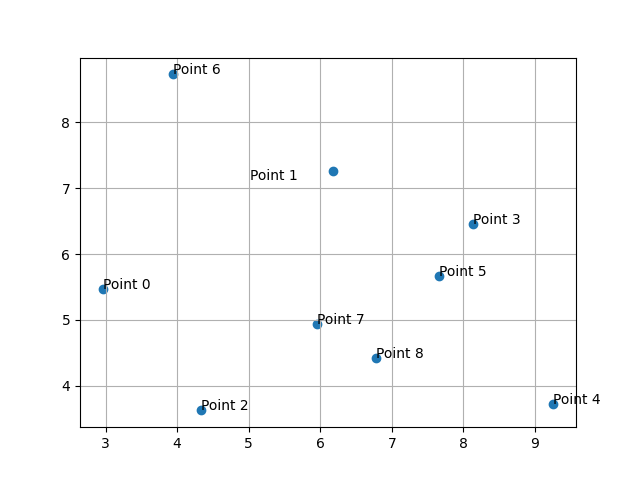

In [ ]:
# Usage example
from numpy import *

# Create arbitrary points and labels
x, y = random.normal(5, 2, size=(2, 9))
labels = [ "Point %d" % i for i in range(x.size)]

# trace a scatter plot
p.scatter(x, y)
p.grid()

# add labels and set their picker attribute to True
for a,b,l in zip(x,y, labels):
    p.text(a, b, l, picker=True)

# Create the event hendler 
dragh = DragHandler()

p.show()

## Or folium/ipyleaflet 

*Better use ipyleaflet for python intergration.*

https://blog.ouseful.info/2019/04/02/fragment-components-for-rolling-your-own-gis-inside-jupyter-notebooks/

Should be possible to add a draggable marker: https://stackoverflow.com/questions/54052995/i-want-to-move-one-marker-to-another 



https://stackoverflow.com/questions/62538396/leaflet-folium-creating-a-fantasy-map-removing-the-world-map


    import folium

    def create_aldrune_map():
        base_map = folium.Map(crs='Simple', zoom_start=4, tiles=None)  # added tiles=None 

        aldrune_overlay = folium.raster_layers.ImageOverlay(
            image='Path/To/Image',
            bounds=[[0, 0], [1000, 1300]],
            zindex=1)
        aldrune_overlay.add_to(base_map)
        base_map.fit_bounds(bounds=[[0, 0], [1000, 1300]])

        base_map.save('Path/To/Output')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
im = plt.imread('/home/frank/Work/ILLs/Primrose.jpg')

In [ ]:
im.shape

(972, 1296, 3)

The difference between folium an ipyleaflet is that the latter is two directional... 

In [ ]:
import folium 
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl

#watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

#m = Map(layers=(watercolor, ), center=(50, 354), zoom=5, tiles=None)
#m = Map(center=(50, 354), zoom=5, tiles=None)

basemap = folium.Map(crs='Simple', zoom_start=0, tiles=None, width=1296/2, height=972/2)
basemap.fit_bounds(bounds=[[0, 0], [972/2, 1296/2]])

primrose_overlay = folium.raster_layers.ImageOverlay(image='/home/frank/Work/ILLs/Primrose.jpg', 
                                                    bounds=[[0, 0], [972/2, 1296/2]])
primrose_overlay.add_to(basemap)

marker_1 = folium.Marker(location=[100, 100], draggable=True, tooltip='top left', popup='X')

marker_1.add_to(basemap)
#draw_control = DrawControl()

#m.add_control(draw_control)

basemap

In [ ]:
basemap.width

(648.0, 'px')

https://stackoverflow.com/questions/54052995/i-want-to-move-one-marker-to-another

## Or bqplot

https://github.com/bqplot/bqplot/blob/master/examples/Introduction.ipynb

In [ ]:
from bqplot import pyplot as plt

In [ ]:
im = np.zeros([10, 10])
im[3:5, 6:8] = 1

In [ ]:
x_data = [1.0, 2.0, 4.0, 1.6] # make floats! 
y_data = [3.1, 1.0, 2.1, 6.2]

In [ ]:
def foo(change):
    #print("This is a trait change. Foo was called by the fact that we moved the Scatter")
    print(scatter_plot.y, end='\r')

In [ ]:
plt.figure(title="My First Plot")

#plt.imshow(im)
scatter_plot = plt.scatter(x_data, y_data)
scatter_plot.enable_move = True
scatter_plot.x = x_data
scatter_plot.y = y_data
scatter_plot.observe(foo, 'y')
plt.show()



In [ ]:
def foo(change):
    #print("This is a trait change. Foo was called by the fact that we moved the Scatter")
    print(scatter_plot.y, end='\r')
    

In [ ]:
scatter_plot.observe(foo, "y_data")

Now, I need to learn how to plot an image below. 